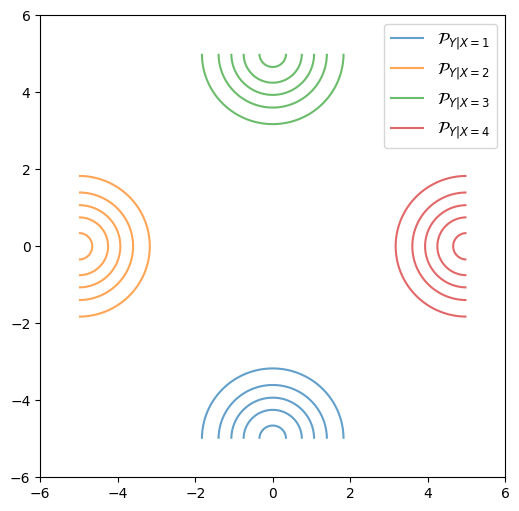

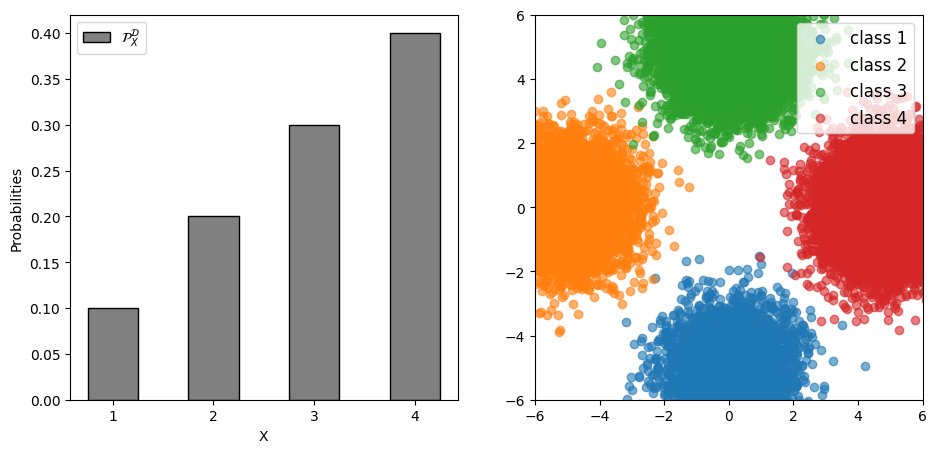

In [1]:
import torch
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from misc.metrics import *
torch.manual_seed(0)

inference_prior = torch.tensor([4,3,2,1])/10
locations = 5*torch.tensor([[0.,-1.],[-1.,0.],[0.,1.],[1.,0.]])
def sample_DGP(number_samples, prior):
    x = torch.distributions.Categorical(prior)
    mvn = torch.distributions.MultivariateNormal(locations, torch.eye(2).unsqueeze(0).repeat(locations.shape[0],1,1))
    labels  = torch.nn.functional.one_hot(x.sample(number_samples), num_classes = prior.shape[0]).unsqueeze(-1)
    obs = torch.sum(mvn.sample(number_samples)*labels, dim = 1)
    return obs, labels
samples_obs, labels_obs = sample_DGP([1000],inference_prior)

def plot_2d_contour(f,range = [[-10,10],[-10,10]], bins = [50,50],levels = 4, alpha = 0.7,show = True,color = None):
    with torch.no_grad():
        tt_x = torch.linspace(range[0][0], range[0][1], bins[0])
        tt_y = torch.linspace(range[1][0],range[1][1], bins[1])
        mesh = torch.cartesian_prod(tt_x, tt_y)
        with torch.no_grad():
            plot=plt.contour(tt_x,tt_y,f(mesh).numpy().reshape(bins[0],bins[1]).T,levels = levels, colors = color, alpha = alpha)
    if show:
        plt.show()
    return plot
plt.figure(figsize = (6,6))
plt.xlim([-6,6])
plt.ylim([-6,6])
list_handles = []
for i in range(4):
    distribution = torch.distributions.MultivariateNormal(locations[i], torch.eye(2))
    contour = plot_2d_contour(lambda x: torch.exp(distribution.log_prob(x)),bins = [200,200], range =[[-5,5],[-5,5]],levels = 5, show = False, color = 'C'+str(i))
    handles, labels = contour.legend_elements()
    list_handles.append(handles[0])
plt.legend(list_handles, [r'$\mathcal{P}_{Y|X=1}$',r'$\mathcal{P}_{Y|X=2}$',r'$\mathcal{P}_{Y|X=3}$',r'$\mathcal{P}_{Y|X=4}$'], ncol = 1, fontsize = 12, loc = 'upper right')
plt.show()

dataset_prior = torch.tensor([1,2,3,4])/10
r = np.arange(4)
total_numbers = 30000
index = torch.distributions.Categorical(dataset_prior/torch.sum(dataset_prior)).sample([total_numbers])
number_samples= torch.sum(torch.nn.functional.one_hot(index), dim = 0)

fig = plt.figure(figsize = (11,5))
width = 0.5
ax1 = fig.add_subplot(121)
ax1.bar(range(4),(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'grey',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax1.set_xticks(r,['1','2','3','4']) 
ax1.set_xlabel("X")
ax1.set_ylabel("Probabilities")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_xlim([-6,6])
ax2.set_ylim([-6,6])
samples_0 = torch.randn(number_samples[0],2)+locations[0]
samples_1 = torch.randn(number_samples[1],2)+locations[1]
samples_2 = torch.randn(number_samples[2],2)+locations[2]
samples_3 = torch.randn(number_samples[3],2)+locations[3]
ax2.scatter(samples_0[:,0].numpy(),samples_0[:,1].numpy(), alpha = .6, label ="class 1")
ax2.scatter(samples_1[:,0].numpy(),samples_1[:,1].numpy(), alpha = .6, label ="class 2")
ax2.scatter(samples_2[:,0].numpy(),samples_2[:,1].numpy(), alpha = .6, label ="class 3")
ax2.scatter(samples_3[:,0].numpy(),samples_3[:,1].numpy(), alpha = .6, label ="class 4")
ax2.legend(ncol = 1, fontsize = 12,loc = 'upper right')

samples = torch.cat([samples_0, samples_1, samples_2, samples_3])
labels = torch.cat([torch.zeros(number_samples[0]), torch.ones(number_samples[1]), 2*torch.ones(number_samples[2]), 3*torch.ones(number_samples[3])]).long()
plt.show()

In [2]:
class GaussianClassifier:
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels
        self.sample_dim = samples.shape[-1]
        self.C = labels.shape[-1]
        self.mu_0 = torch.zeros(self.sample_dim)
        self.Psi_0 = torch.eye(self.sample_dim)
        self.lbda = 1
        self.nu = 10
    
    def sample_theta_from_posterior(self, num_samples, samples = None, labels = None):
        list_means = []
        list_Sigmas = []
        if samples is None:
            samples = self.samples
        if labels is None:
            labels = self.labels
        for c in range(self.C):
            samples_c = samples[labels[:,c]==1]
            N_c = samples_c.shape[0]
            lbda_N_c = self.lbda + N_c
            nu_N_c = self.nu + N_c
            empirical_mean_c = torch.mean(samples_c, dim =0)
            mu_N_c = (self.lbda*self.mu_0 + N_c*empirical_mean_c)/lbda_N_c
            S_c = torch.cov(samples_c.T)*(N_c-1)
            temp = (empirical_mean_c-self.mu_0).unsqueeze(-1)
            Psi_N_c = self.Psi_0 + S_c + (self.lbda*N_c*temp@temp.T)/(lbda_N_c)
            Sigma_c = torch.inverse(torch.distributions.Wishart(nu_N_c,torch.inverse(Psi_N_c)).sample(num_samples))
            means_c = torch.distributions.MultivariateNormal(mu_N_c, Sigma_c/lbda_N_c).sample()
            list_means.append(means_c.unsqueeze(1))
            list_Sigmas.append(Sigma_c.unsqueeze(1))
        return torch.cat(list_means, dim = 1), torch.cat(list_Sigmas, dim =1)
    
    def log_prob(self,samples, means, Sigmas, prior):
        mvn = torch.distributions.MultivariateNormal(means,Sigmas).log_prob(samples.unsqueeze(1).unsqueeze(1).repeat(1,means.shape[0],self.C, 1)) + torch.log(prior)
        return mvn - torch.logsumexp(mvn, dim = 2, keepdim =True)
    
    def predict_with_gibbs(self,obs,prior,number_steps=500,samples = None,labels =None):
        means, Sigmas = self.sample_theta_from_posterior([1])
        for t in tqdm(range(number_steps)):
            log_prob = self.log_prob(obs, means, Sigmas, prior)[:,0,:]
            labels = torch.distributions.Categorical(torch.exp(log_prob)).sample()
            augmented_labels = torch.cat([torch.nn.functional.one_hot(labels, num_classes = self.C), self.labels], dim = 0)
            augmented_samples = torch.cat([obs, self.samples], dim=0)
            means, Sigmas = self.sample_theta_from_posterior([1], augmented_samples, augmented_labels)
        return log_prob

c:\users\elouan\pycharmprojects\experiments\venv\lib\site-packages\torch\distributions\wishart.py:250: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


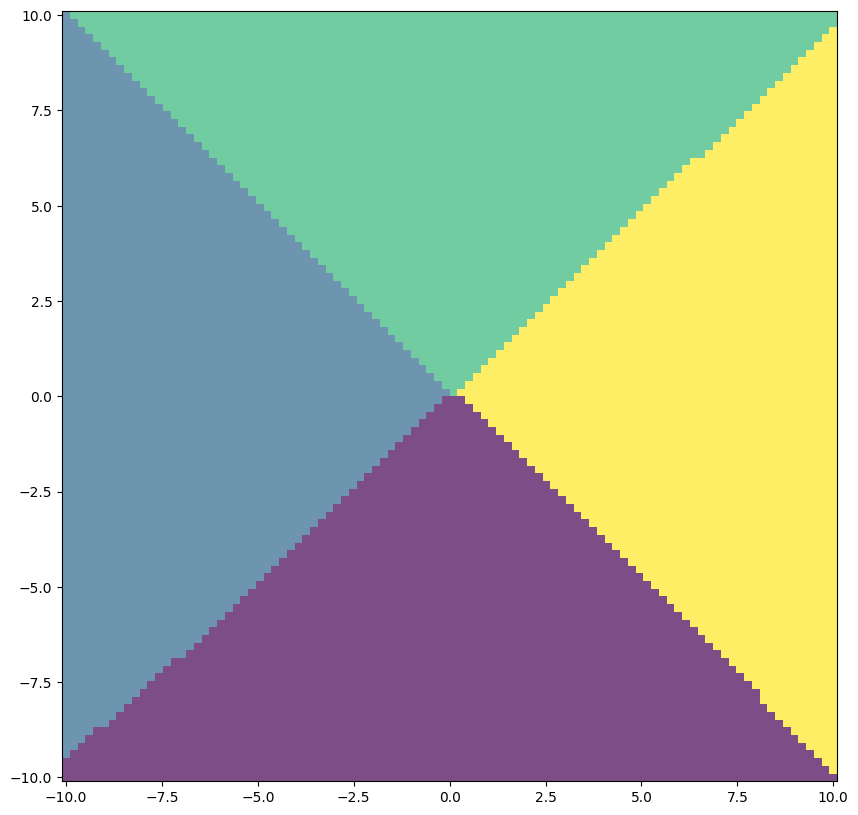

In [3]:
from utils import *
fig = plt.figure(figsize = (10,10))
model = GaussianClassifier(samples, torch.nn.functional.one_hot(labels))
mean_posterior,Sigma_posterior = model.sample_theta_from_posterior([100])
plot_2d_function(lambda samples: torch.argmax(torch.mean(torch.exp(model.log_prob(samples,mean_posterior,Sigma_posterior,  inference_prior)), dim = 1),dim = -1), bins = [100,100], range = [[-10,10],[-10,10]])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 130.25it/s]


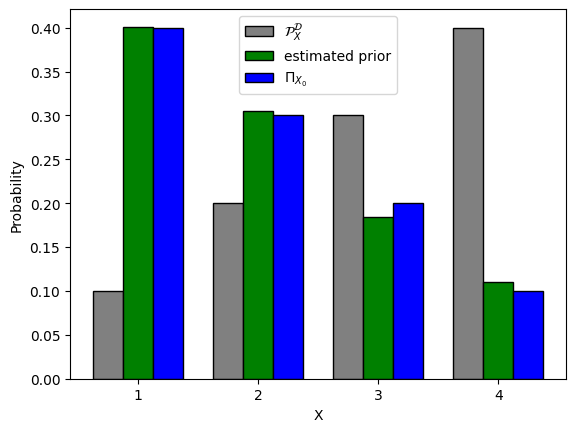

In [4]:
list_log_prob = torch.mean(torch.exp(model.predict_with_gibbs(samples_obs,inference_prior)), dim =0)

r = np.arange(4) 
width = 0.25

plt.figure()
ax = plt.subplot(111)
ax.bar(r+2*width,(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'grey',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax.set_xticks(r+3*width,['1','2','3','4']) 
ax.set_xlabel("X")
ax.set_ylabel("Probabilities")
ax.bar(r+3*width, list_log_prob, color = 'g', 
        width = width, edgecolor = 'black', 
        label='estimated prior') 
ax.bar(r+4*width, inference_prior, color = 'b', 
        width = width, edgecolor = 'black', 
        label=r'$\Pi_{X_0}$') 


ax.legend()


  
plt.xlabel("X") 
plt.ylabel("Probability") 

plt.legend() 
  
plt.show() 